In [64]:
import json
import os

import numpy as np

from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, Trials

In [ ]:
os.chdir("/Users/ruotsing/PycharmProjects/DMS")
with open("preprocess_data/SWA_data.json", "r") as f:
    SWA_data = json.load(f)
    
with open("preprocess_data/ground_truth.json", "r") as f:
    ground_truth = json.load(f)    
    
def time_derivative(data, time_interval):
    data_dt = {}
    for name in data.keys():
        delta_displacement = np.diff(data[name])
        data_dt[name] = np.gradient(delta_displacement, time_interval)
    return data_dt

sample_rate = 100
SWV_data= time_derivative(SWA_data, 1/sample_rate)

size_= 3
step = 1
ground_truth=reform_ground_truth(ground_truth)
awake_window, light_drowsy_window, drowsy_window,general_window=ground_truth_sep(ground_truth,size_,step)

def define_feature_matrix(awake_window, light_drowsy_window, drowsy_window,general_window, SWA_data,SWV_data):
    feature_matrix = {}
    label = {}
    for name in general_window.keys():
        feature_matrix[name] = []
        label[name] = []
        for i in range(len(general_window[name])):
            begin = general_window[name][i][0]*sample_rate
            end = (general_window[name][i][-1]+1)*sample_rate
            SWA_data[name][begin:end]=SWA_data[name][begin:end]-np.mean(SWA_data[name][begin:end])
            energy_SWA = np.sum([i**2 for i in SWA_data[name][begin:end]])
            zcr_SWV = np.sum(np.abs(np.diff(np.sign(SWV_data[name][begin:end])))) / 2
            kurtosis_SWV = np.mean((SWV_data[name][begin:end] - np.mean(SWV_data[name][begin:end])) ** 4) / (np.std(SWV_data[name][begin:end]) ** 4)
            samEn_SWA = -np.log(np.sum(np.exp(-np.abs(np.diff(SWA_data[name][begin:end])))) / len(SWA_data[name][begin:end]))
            samEn_SWV = -np.log(np.sum(np.exp(-np.abs(np.diff(SWV_data[name][begin:end])))) / len(SWV_data[name][begin:end]))
            feature_matrix[name].append([energy_SWA, zcr_SWV, kurtosis_SWV, samEn_SWA, samEn_SWV])
            if tuple(general_window[name][i]) in awake_window[name]:
                label[name].append(0)
            if tuple(general_window[name][i]) in light_drowsy_window[name]:
                label[name].append(1)
            if tuple(general_window[name][i]) in drowsy_window[name]:
                label[name].append(2)
        feature_matrix[name]=np.array(feature_matrix[name])        
        label[name]=np.array(label[name])
    return feature_matrix, label


feature_matrix, label = define_feature_matrix(awake_window, light_drowsy_window, drowsy_window,general_window, SWA_data,SWV_data)

In [15]:



def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    y_pred=[]
    for row in model.predict(X_test):
        y_pred.append(np.argmax(row))
    y_pred=np.array(y_pred)    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()

In [ ]:


def prepare_input(feature_matrix, label,drivers):
    result_matrix=np.empty((0,feature_matrix[drivers[0]].shape[1]))
    result_label=np.empty((0,))
    for name in drivers:
        result_matrix=np.concatenate((result_matrix,feature_matrix[name]),axis=0)
        result_label=np.concatenate((result_label,label[name]),axis=0)
        
    return result_matrix, result_label  


drivers_train= ['catia', 'giulio', 'vasanth', 'emanuele', 'michele', 'stefano']
drivers_test = ['gea']

X_train, y_train = prepare_input(feature_matrix, label, drivers_train)
y_train = y_train.astype(int)
X_rest, y_rest = prepare_input(feature_matrix, label, drivers_test)
y_rest = y_rest.astype(int)
split_point = int(len(X_rest)/2)
X_val=X_rest[:split_point]
y_val=y_rest[:split_point]
X_test=X_rest[split_point:]
y_test=y_rest[split_point:]

In [38]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [55]:

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [68]:
space = {
    'neurons_1': hp.choice('neurons_1', [32, 64, 128]),
    'neurons_2': hp.choice('neurons_2', [32, 64, 128]),
    'neurons_3': hp.choice('neurons_3', [32, 64, 128]),
    'mini_batch_size': hp.choice('mini_batch_size', [32, 64, 128]),
}

space_params = {
    'neurons_1': [32, 64, 128],
    'neurons_2': [32, 64, 128],
    'neurons_3': [32, 64, 128],
    'mini_batch_size': [32, 64, 128],
}  

In [73]:
 # Neural Network
def make_model(space, best_params):
    model=tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(space['neurons_1'][best_params['neurons_1']], activation='tanh'),
    tf.keras.layers.Dense(space['neurons_2'][best_params['neurons_2']], activation='tanh'),
    tf.keras.layers.Dense(space['neurons_3'][best_params['neurons_3']], activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=CategoricalFocalCrossentropy(alpha=list(class_weight_dict.values()), gamma=2.0), 
              metrics=['categorical_accuracy'])
        
    return model

def objective(params):
    model=tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(params['neurons_1'], activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(params['neurons_2'], activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(params['neurons_3'], activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=CategoricalFocalCrossentropy(alpha=list(class_weight_dict), gamma=2.0),metrics=['categorical_accuracy'])

    model.fit(X_train, y_train_one_hot, epochs=150, batch_size=params['mini_batch_size'], verbose=0, validation_data=(X_val, y_val_one_hot))
    f1=f1_score(y_val, np.argmax(model.predict(X_val), axis=1), average='weighted')
    return -f1


y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=3)

trials = Trials()
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

print("Best hyperparameters:", best_params)

best_model = make_model(space_params, best_params)
history=best_model.fit(X_train, y_train_one_hot, epochs=150, batch_size=space_params['mini_batch_size'][best_params['mini_batch_size']], validation_data=(X_val, y_val_one_hot), verbose=0)
confusion_matrix_on_test_data(best_model, 'best_weighted_model', X_test, y_test)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()          

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step                  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step                  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step

 1/58 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step                  
36/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 20%|██        | 4/20 [06:22<25:31, 95.70s/trial, best loss: -0.21037911287569716] 


KeyboardInterrupt: 

670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


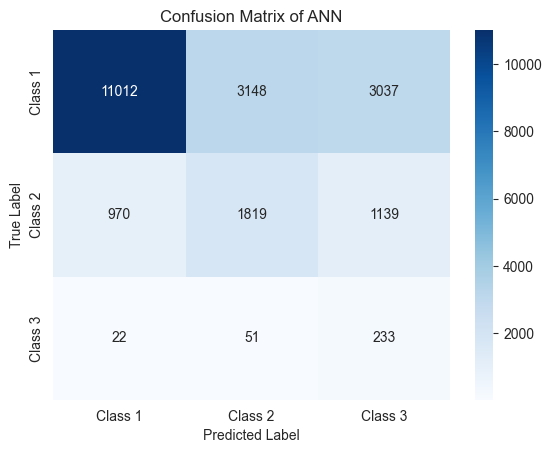

In [50]:
confusion_matrix_on_test_data(best_model,'ANN', X_train, y_train)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step


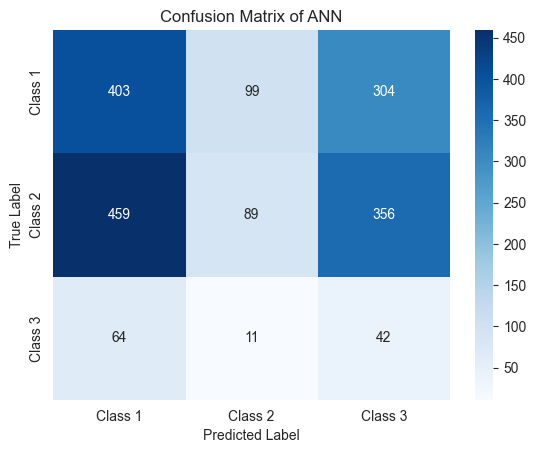

In [57]:
confusion_matrix_on_test_data(model,'ANN', X_test, y_test)